## 2. Create a Data Lake using AWS Lake Formation

No tópico anterior, mostramos como fazer a ingestão em streaming, usando kinesis para enviar dados para a Source Zone do data lake. Além, da source, o data lake também será constituído de outras duas zonas, a landing e a curated: Vamos falar em detalhes sobre cada uma delas:

**Source Zone (Bronze)**: A source zone é a camada inicial do data lake e contém os dados brutos, em seu formato original, sem nenhum processamento ou transformação significativa. Esses dados podem ser provenientes de várias fontes, como registros de logs, dados de sensores, arquivos CSV, json, bancos de dados etc. A camada bronze é projetada para capturar e armazenar todos os dados de maneira eficiente, sem se preocupar com a estruturação ou organização detalhada dos mesmos.

**Landing Zone (Silver)**: A camada silver é onde ocorre o processo de refinamento dos dados brutos. Nessa camada, os dados são limpos, estruturados e transformados em um formato mais legível e fácil de usar. Isso pode incluir a aplicação de esquemas e metadados, normalização, padronização e agregação de dados. A camada silver visa garantir que os dados sejam mais confiáveis, consistentes e prontos para análises mais avançadas. Esses dados refinados geralmente são organizados em estruturas de dados tabulares no formato parquet, como tabelas ou colunas.

**Curated Zone (Gold)**: A camada gold é a camada final e de maior qualidade do data lake. Nessa camada, os dados são altamente refinados e otimizados para atender a requisitos específicos de análise e geração de insights. Isso pode envolver a aplicação de transformações adicionais, combinação de diferentes conjuntos de dados, cálculos de métricas personalizadas e até mesmo a criação de modelos analíticos avançados. A camada gold é destinada a usuários e casos de uso mais avançados, que exigem dados altamente confiáveis e prontos para análises complexas.

No nosso projeto, vamos receber na source zone dados brutos, em formato json, de avaliações de usuários. Em muitas aplicações o formato json está pouco estruturado, com dicionários dentro de dicionários, e arquivos corrompidos em muitos casos. Daí a necessidade de refiná-los ao enviar para a landing zone. Um job no Glue pode ser criado para estruturar os dados e convertê-los para parquet. Isso permitiria fazer consultas usando Athena. Nesse etapa deve-se perder o mínimo de informação possível com relação aos dados da source. Já na curated zone, os dados são refinados para propósitos específicos, como extrair variáveis para aplicação em modelo de machine learning e sistemas de recomendação. 

Com o Glue podemos criar jobs que irão processar os dados e também catálogá-los, permitindo fazer queries nas tabelas. Para a source zone, a catalogação é opcional, já que os dados podem estar tão desestruturados que nem o Crawler conseguiria torná-lo legível.

Seria interessante um serviço que centraliza o nosso datalake, daí a necessidade do Lake Formation. O Lake Formation é um serviço da AWS que justamente facilita a criação, configuração e gerenciamento de um data lake na nuvem. Ele fornece uma série de recursos e ferramentas para ajudar na ingestão, organização, segurança e governança dos dados em um ambiente de data lake, como:

**Ingestão simplificada de dados**: O Lake Formation permite que você ingira dados de várias fontes, como bancos de dados relacionais, serviços de armazenamento em nuvem, serviços de streaming e muito mais. Ele oferece integração direta com como o S3, RDS e o Amazon Redshift, para facilitar a transferência de dados para o data lake.

**Organização e estruturação de dados**: O serviço oferece recursos para organizar e estruturar os dados em seu data lake. Você pode criar tabelas, definir esquemas, particionar dados e aplicar transformações para melhorar a qualidade e a eficiência dos dados armazenados.

**Segurança e governança de dados**: O Lake Formation ajuda a garantir a segurança dos dados em seu data lake. Ele permite definir políticas de acesso granulares, controlar o acesso aos dados com base em funções e permissões e aplicar criptografia para proteger os dados em repouso e em trânsito. Além disso, o serviço ajuda a garantir a conformidade com regulamentações e políticas de segurança.

**Controle de acesso e governança**: O serviço permite que você gerencie o acesso aos dados por meio de políticas de acesso centralizadas. Você pode controlar quem pode visualizar, modificar ou excluir dados específicos com base em funções e permissões definidas. Além disso, o Lake Formation ajuda a garantir a conformidade com políticas e regulamentações de privacidade de dados.

**Integração com serviços analíticos**: O Lake Formation facilita a integração com serviços analíticos da AWS, como o Athena, o Redshift e o EMR. Isso permite que você execute consultas SQL, análises avançadas e processamento de big data nos dados armazenados em seu data lake.

A arquitetura que criaremos será essa: Um bucket do S3 armazenará as três zonas de dados. O kinesis envia dados brutos para a source, e dois jobs do glue enviarão os dados processados para a zona landing e curated, que também serão catalogadas. Organização, permissões e governança dos dados serão centralizadas no lake formation. A partir da curated os dados já estarão prontos para serem usados em jobs analíticos, usando sagemaker, por exemplo.

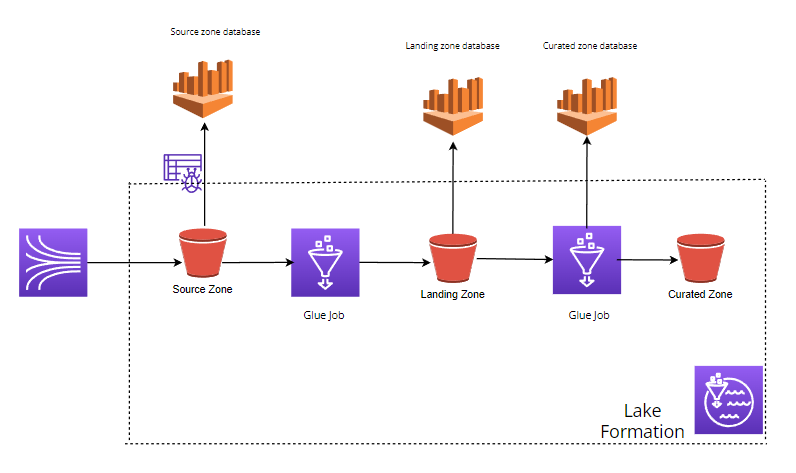

Para configurar o lake formation, resumidamente devemos seguir as seguintes etapas:
1. Criar um usuário IAM que será o administrador do datalake;
2. criar roles com as devidas permissões para o glue;
3. criar bases de dados para cada uma das zonas, e indicar a localização no s3;
4. configure a localização do datalake;
5.  Forncer as devidas permissões do lake formation aos usuários e roles. Essa permissões podem ser de nível de database, tabela ou até mesmo de linha.

### Etapa 1 

Crie uma policy  IAM ***passrole_policy*** que dará acesso para usuários e roles passar uma role:

In [2]:
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:PassRole"
            ],
            "Resource": "*"
        }
    ]
}

{'Version': '2012-10-17',
 'Statement': [{'Effect': 'Allow',
   'Action': ['iam:GetRole', 'iam:PassRole'],
   'Resource': '*'}]}

1. Crie um usuário IAM com um nome da sua escolha, chamarei de ***DatalakeAdmin***
2. Anexe as policies gerenciadas da AWS:
    - AWSLakeFormationDataAdmin
    - AmazonAthenaFullAccess
    - IAMReadOnlyAccess
    - AmazonS3FullAccess
    - AWSGlueConsoleFullAccess
    - CloudWatchLogsReadOnlyAccess
3. E anexe a policy customizada:
    - passrole_policy

### Etapa 2

1. Crie a role ***GlueETLServiceRole*** com os seguinte trust relationship para o Glue

In [2]:
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": [
          "glue.amazonaws.com"
        ]
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

{'Version': '2012-10-17',
 'Statement': [{'Effect': 'Allow',
   'Principal': {'Service': ['glue.amazonaws.com']},
   'Action': 'sts:AssumeRole'}]}

2. Crie uma policy IAM ***S3DataLakePolicy***, que dará acesso ao bucket do datalake. subistitua <datalake-bucket> pelo nome do bucket

In [3]:
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject",
                "s3:GetObject",
                "s3:DeleteObject"
            ],
            "Resource": [
                "arn:aws:s3:::<datalake-bucket>/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::<datalake-bucket>/*"
            ]
        }
    ]
}


{'Version': '2012-10-17',
 'Statement': [{'Effect': 'Allow',
   'Action': ['s3:PutObject', 's3:GetObject', 's3:DeleteObject'],
   'Resource': ['arn:aws:s3:::<datalake-bucket>/*']},
  {'Effect': 'Allow',
   'Action': ['s3:ListBucket'],
   'Resource': ['arn:aws:s3:::<datalake-bucket>/*']}]}

3. Anexe em GlueETLServiceRole as policies gerenciadas da AWS:
    - AWSGlueServiceRole
    - AWSLakeFormationDataAdmin
    - AmazonKinesisReadOnlyAccess
4. Anexe as policies customizada:
    - S3DataLakePolicy
    - passrole_policy

### Etapa 3

1. Em ***Data catalog***, escolha ***Settings***. Verifique se as duas caixas de seleção Usar somente controle de acesso do IAM para novos bancos de dados e Usar somente controle de acesso do IAM para novas tabelas em novos bancos de dados estão desmarcadas.
2. Em ***Data catalog***, escolha ***Databases***.
3. Escolha ***Create Database***.
4. Selecione ***Database***.
5. Em ***Name***, escreva sourcezone.
6. Faça o mesmo para criar a landingzone e curatedzone (opcionalmente adicione a localização no s3 da base de dados).

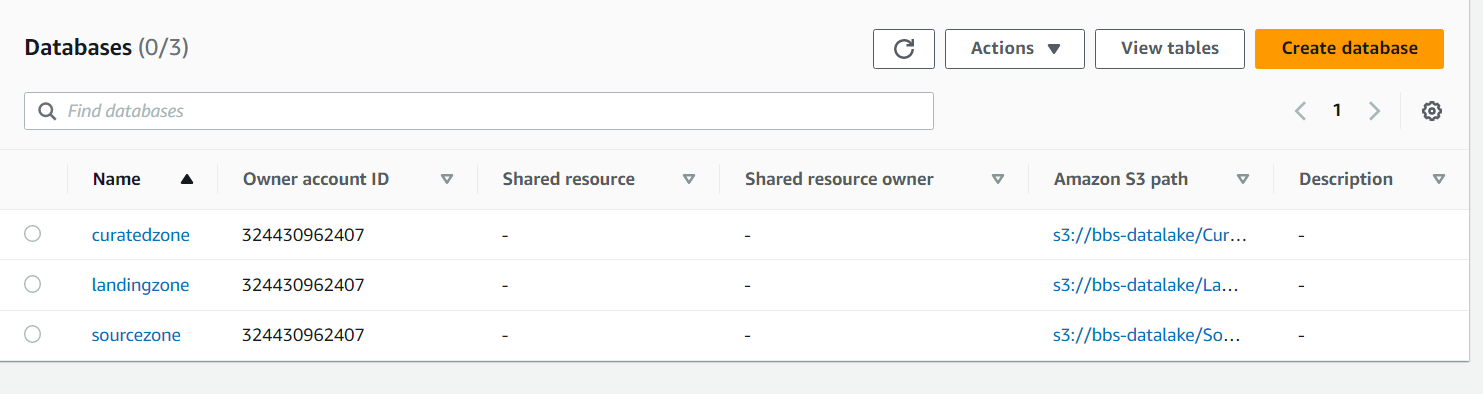

### Etapa 4

1. No console do ***Lake Formation*** , em ***Permissions***, choose ***Manage Administrators***.
2. Em  ***IAM users and roles***, escolha seu usuário IAM ***DatalakeAdmin*** e salve.
3. Em  ***Database creators*** , escolha ***Grant***.
4. Em  ***IAM users and roles***, escolha ***AWSServiceRoleForLakeFormationDataAccess*** e clique em ***Create Database***
5. Troque para a conta ***DataLakeAdmin***

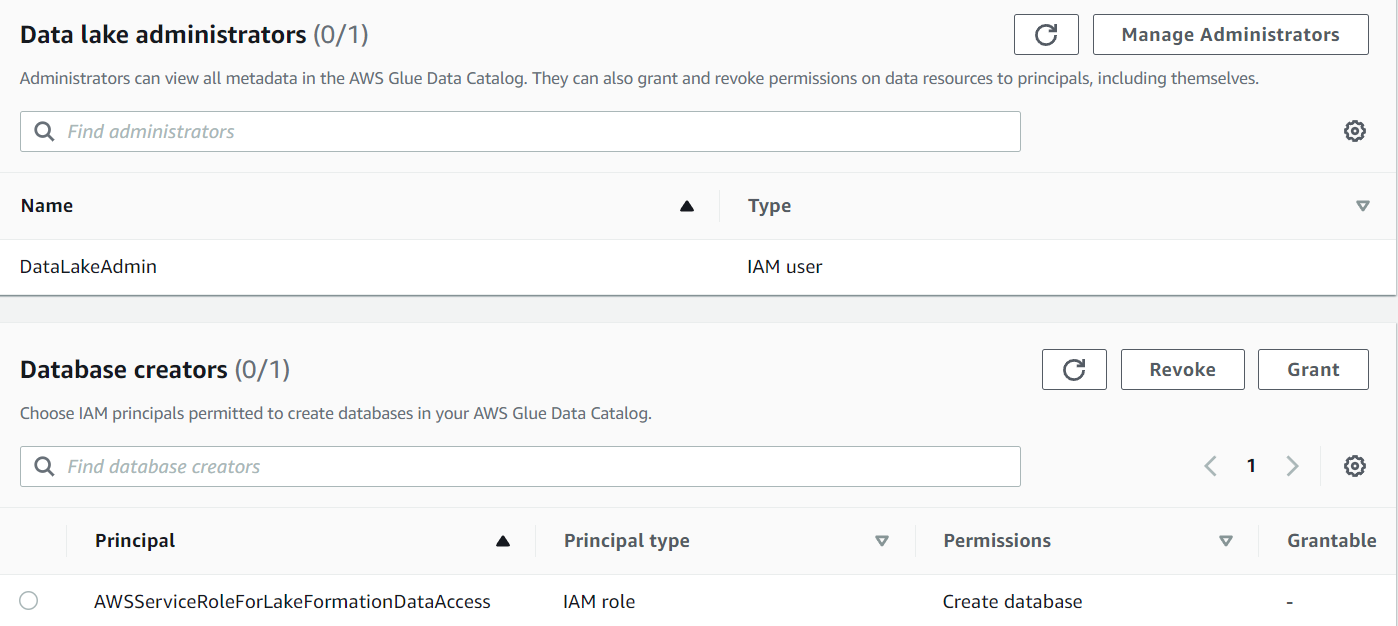

1. Em ***Register and ingest***, escolha ***Data lake locations***.
2. Escolha ***Register location***.
3. Para o caminho do Amazon S3, insira ***s3://< datalake-bucket >/*** . O Lake Formation usa essa função para dar credenciais temporárias do Amazon S3 para consultar serviços que precisam de acesso de leitura/gravação ao bucket e a todos os prefixos sob ele.
4. Para a função do IAM, escolha ***AWSServiceRoleForLakeFormationDataAccess***.
Escolha ***Register location***.

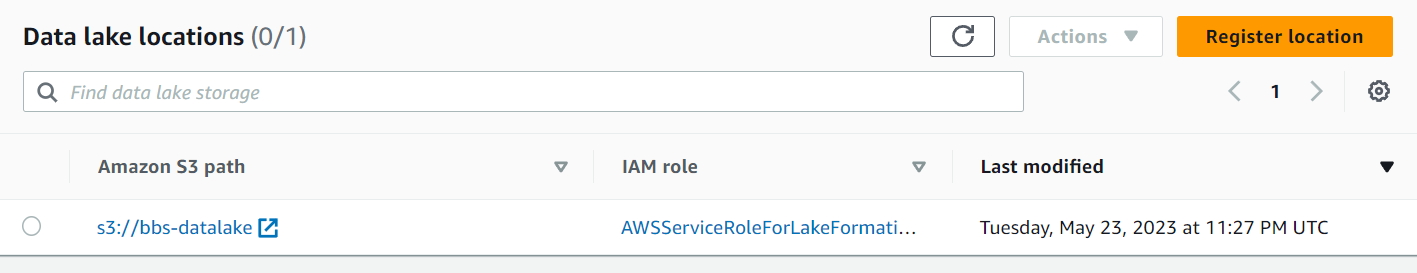

5. Em ***Permissions***, vá para ***Data locations*** e clique em ***Grant***.
6. Em ***IAM users and roles*** escolha ***GlueETLServiceRole***.
7. Em **Storage locations*** insira ***s3://< datalake-bucket >/***. Isso dará as devidas permissões do lake formation para o job do Glue escrever nesse bucket.

### Etapa 5a - Permissões de database

Isso dará permissão ao role do Glue para fazer a criação e alteração de tabelas em um database do Lake Formation.
1. Em ***Permissions***, escolha ***Data permissions*** e clique em ***Grant.
2. Em database escolha ***sourcezone***.
3. Em ***IAM users and roles***, escolha a role ***GlueETLServiceRole*** e ***DataLakeAdmin***.
4. Selecione ***Database permissions*** e selecione ***Create Table, Alter, Drop***, e ***Describe***. Clique em ***Grant***.
5. Faça o mesmo para a landingzone e curatedzone. 

***Obs:*** Ao executar um job do Glue com um tabela ***Iceberg***, ele cria uma database chamada ***default***. Para evitar problemas de permissão do lake formation, conceda ao job do Glue acesso ***super*** a essa database.

### Etapa 5b - Permissões de tabela

Isso dará ao role do Glue para selecionar e descrever uma tabela em específico. No nosso caso vamos dar acesso a todas as tabelas de um database. 
1. Em ***Permissions***, escolha ***Data permissions*** e clique em ***Grant.
2. Em database escolha ***sourcezone***.
3. Em ***Table***, escolha ***All tables***.
4. Em ***IAM users and roles***, escolha a  role ***GlueETLServiceRole*** e ***DataLakeAdmin***.
5. Selecione ***Table permissions***.
6. Em ***Table permissions***, selecione ***Super***. Clique em ***Grant***.

Para a etapa 6, seria interessante dar ao usuário raiz e IAM administrador do datalake as permissões de criar e alterar databases e tabelas. Basta adicionar um usuário IAM em ***IAM users and roles*** junto com a role do GLue

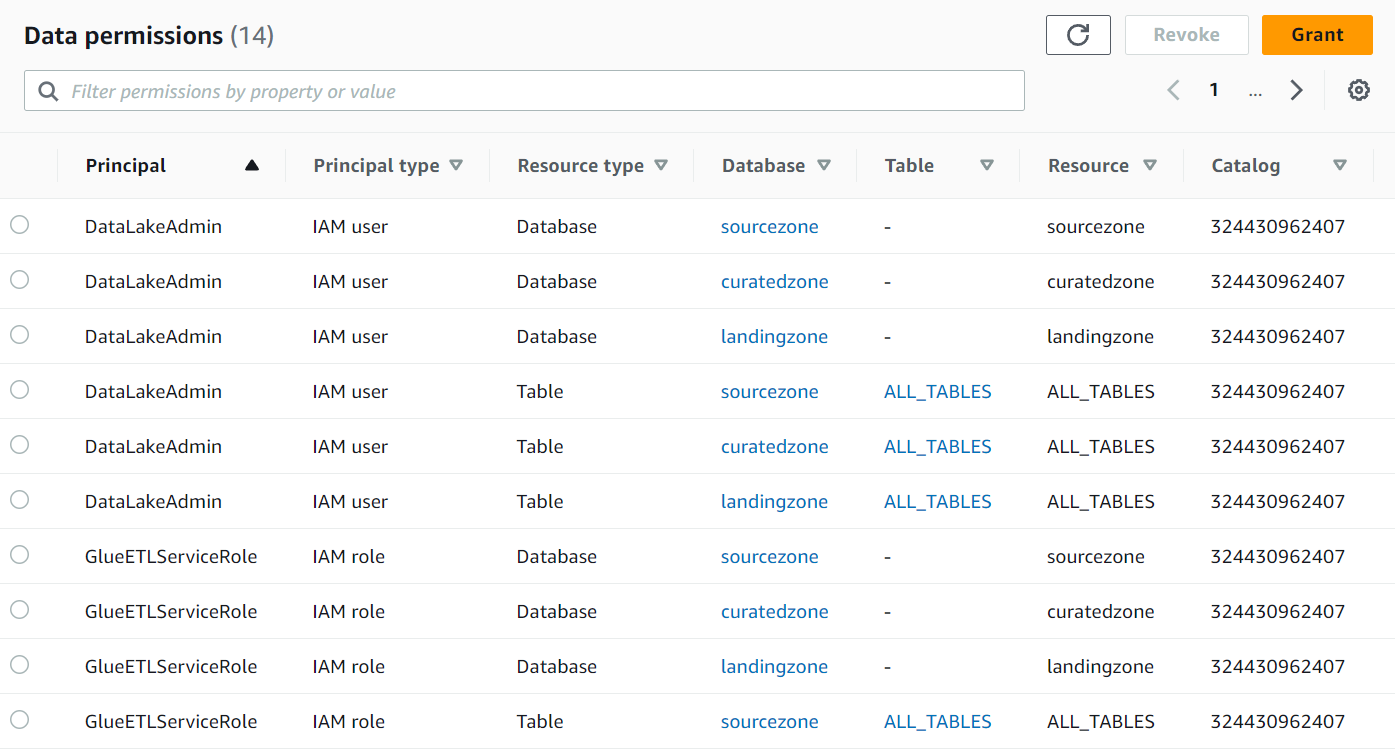

Também é possível criar permissionamentos em nível de linha, por exemplo, criando uma query e usando uma LF-tag que irá marcar as células da tabela que a query retorna. O controle por ***LF-tag*** é outra maneira de configurar permissões. Uma tag pode ser criada para uma linha, coluna, tabela, ou database e o administrador pode configurar quem tem acesso aos dados marcados por ela. 